In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid")

In [329]:
bici=pd.read_csv("./csv/bicimuestra.csv")
estacion=pd.read_csv("./csv/estaciones.csv")
direccion=pd.read_json("./csv/direcciones.json")

In [330]:
bici=bici.drop(columns=["Unnamed: 0","Fecha_Arribo","Fecha_Retiro"])

In [331]:
import json
def dictToDf(listOfJSON):
    arr = []
    for i in listOfJSON:
        arr.append(i)
    return pd.DataFrame(arr)

In [332]:
tmp=dictToDf(direccion["address"])

In [334]:
direccion=direccion.join(tmp)

In [339]:
direccion=direccion.join(estacion)

In [344]:
direccion.columns

Index(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon',
       'display_name', 'address', 'boundingbox', 'road', 'neighbourhood',
       'county', 'state', 'postcode', 'country', 'country_code', 'residential',
       'address29', 'city', 'convenience', 'hospital', 'house_number', 'hotel',
       'restaurant', 'bicycle_parking', 'fast_food', 'clothes', 'beverages',
       'mall', 'sports_centre', 'wood', 'cycleway', 'cafe', 'bar', 'fuel',
       'supermarket', 'building', 'museum', 'parking', 'pedestrian',
       'memorial', 'furniture', 'school', 'bicycle', 'place_of_worship',
       'attraction', 'pharmacy', 'footway', 'swimming_pool', 'kindergarten',
       'library', 'computer', 'university', 'guest_house', 'car_repair',
       'bank', 'post_office', 'bus_station', 'track', 'stationery', 'pitch',
       'theatre', 'laundry', 'bakery', 'beauty', 'pub', 'ID', 'Nombre',
       'Dirección', 'Número', 'Código postal', 'districtCode', 'Colonia',
       'altitude', 'nearbyStation

In [340]:
cols=["ID","Nombre","lat","lon","Tipo de estación","Dirección","districtCode","county","postcode"]
changea=["a_ID","a_Nombre","a_lat","a_lon","a_Tipo de estación","a_Dirección","a_districtCode","a_county","a_postcode"]
changer=["r_ID","r_Nombre","r_lat","r_lon","r_Tipo de estación","r_Dirección","r_districtCode","r_county","r_postcode"]

In [350]:
df=pd.merge(bici,direccion[cols],left_on="Ciclo_Estacion_Arribo",right_on="ID",how="inner")
df=df.rename(columns=dict(zip(cols,changea)))

In [351]:
df=pd.merge(df,direccion[cols],left_on="Ciclo_Estacion_Retiro",right_on="ID",how="inner")
df=df.rename(columns=dict(zip(cols,changer)))

In [353]:
df["Hora_Arribo"]=pd.to_datetime(df["Hora_Arribo"])
df["Hora_Retiro"]=pd.to_datetime(df["Hora_Retiro"])

In [354]:
df.isnull().sum().to_frame()

,0
Bici,0
Ciclo_Estacion_Arribo,0
Ciclo_Estacion_Retiro,0
Edad_Usuario,0
Genero_Usuario,0
Hora_Arribo,0
Hora_Retiro,0
a_ID,0
a_Nombre,0
a_lat,0


In [356]:
# calcula la distancia en base  de la longitud y latitud de dos puntos
from math import radians, sin, cos, acos
def distance(lat1,lon1,lat2,lon2):
    if lat1==lat2 and lon1==lon2:
        return 0
    slat = radians(lat1)
    slon = radians(lon1)
    elat = radians(lat2)
    elon = radians(lon2)
    
    return 6371.01 *acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

In [357]:
df["distancia"]=df.apply(lambda x: distance(x["r_lat"],x["r_lon"],x["a_lat"],x["a_lon"]),axis=1)
df=df[df["Edad_Usuario"]<66]

In [358]:
df["distancia"].describe()

count    169023.000000
mean          1.749877
std           1.315375
min           0.000000
25%           0.823569
50%           1.385493
75%           2.331555
max          10.421930
Name: distancia, dtype: float64

In [359]:
df["minutos_usados"]=(df["Hora_Arribo"]-df["Hora_Retiro"])/ np.timedelta64(1, 'm')

In [360]:
df["h_arribo"]=df["Hora_Arribo"].dt.hour
df["h_retiro"]=df["Hora_Retiro"].dt.hour

In [361]:
df["minutos_usados"].describe(percentiles = [x/10 for x in range(10)] + [0.01, 0.05, 0.95, 0.99])

count    169023.000000
mean         11.592106
std          60.163217
min       -1437.750000
0%        -1437.750000
1%            2.153667
5%            3.433333
10%           4.383333
20%           5.966667
30%           7.450000
40%           9.050000
50%          10.866667
60%          13.083333
70%          15.883333
80%          19.900000
90%          26.616667
95%          33.081667
99%          49.250000
max         965.600000
Name: minutos_usados, dtype: float64

In [362]:
def percentiles(df,variable):
    desc = df[variable].describe(percentiles=[0.01,0.99])
    aux = df.copy()
    return aux[(aux[variable]>desc["1%"]) & (aux[variable]<desc["99%"])]

In [363]:
aux=percentiles(df,"minutos_usados")

In [365]:
aux["minutos_usados"].describe(percentiles = [x/10 for x in range(10)] + [0.01, 0.05, 0.95, 0.99])

count    165639.000000
mean         13.303422
std           8.748409
min           2.166667
0%            2.166667
1%            2.600000
5%            3.616667
10%           4.516667
20%           6.050000
30%           7.516667
40%           9.083333
50%          10.866667
60%          13.033333
70%          15.750000
80%          19.600000
90%          25.900000
95%          31.516667
99%          41.427000
max          49.216667
Name: minutos_usados, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac01f2b80>,
      dtype=object)

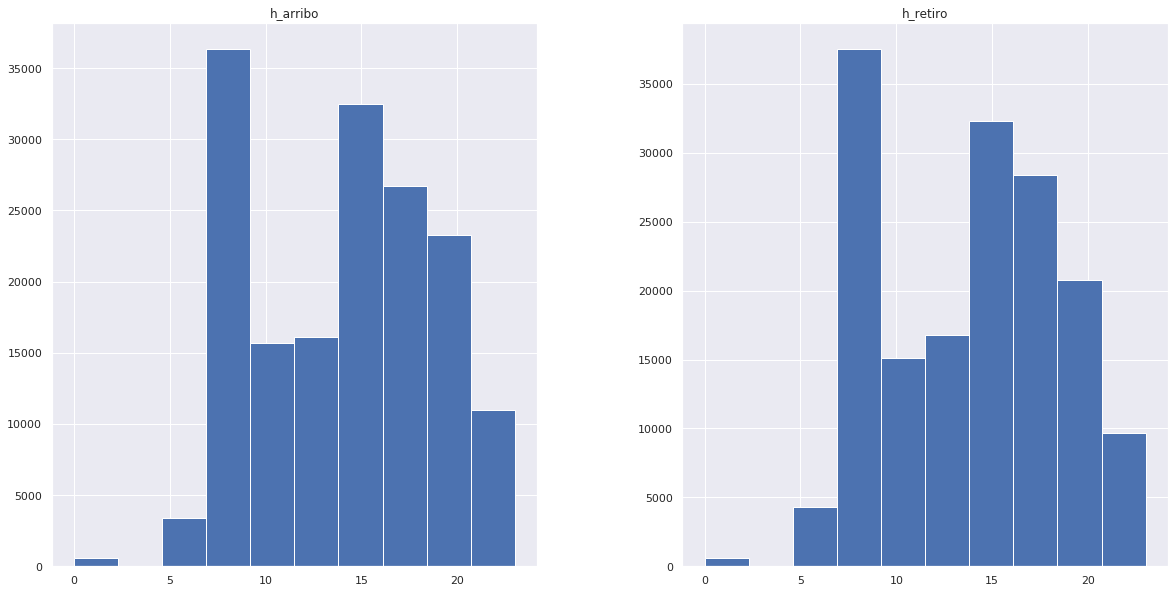

In [366]:
cols=["h_retiro","h_arribo"]
aux[cols].hist(figsize=(20,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faac24c4550>,
      dtype=object)

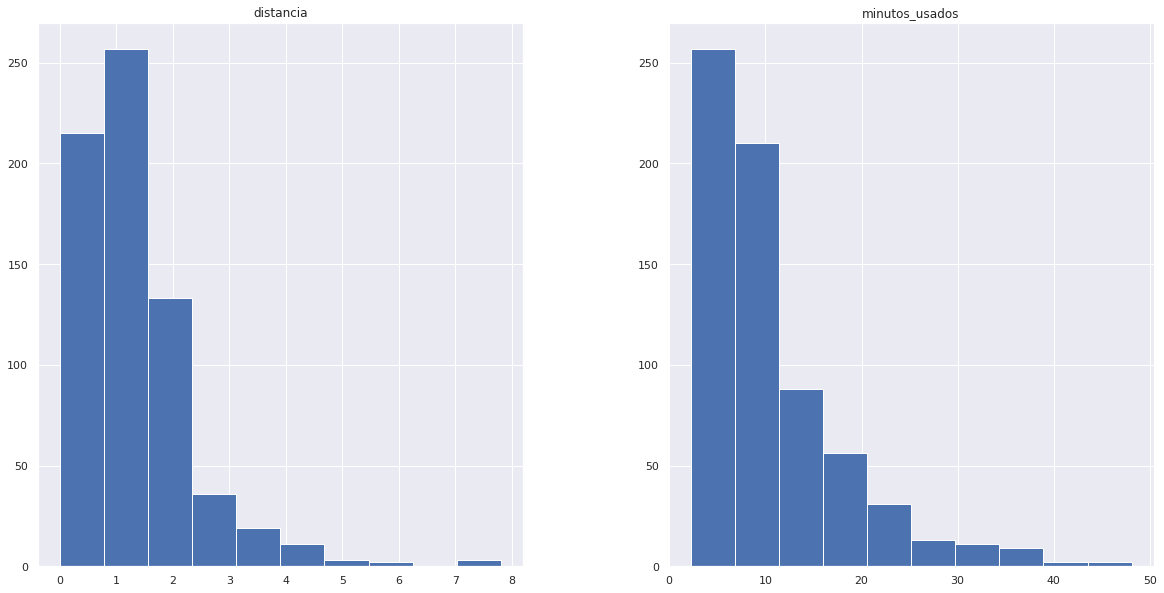

In [367]:
cols=["distancia","minutos_usados"]
aux[aux["Ciclo_Estacion_Arribo"]==211][cols].hist(figsize=(20,10))

In [368]:
aux["r_county"].value_counts()

Cuauhtémoc        96499
Miguel Hidalgo    35809
Benito Juárez     33331
Name: r_county, dtype: int64

In [369]:
aux["a_county"].value_counts()

Cuauhtémoc        100323
Benito Juárez      32841
Miguel Hidalgo     32475
Name: a_county, dtype: int64

In [370]:
aux.groupby(["a_postcode"]).mean()["minutos_usados"].sort_values()

a_postcode
03740    10.593965
03200    10.985555
03330    11.113880
06100    11.418913
11550    11.449871
           ...    
11529    17.606098
03600    17.690879
06000    19.214511
11000    19.362331
11040    19.533994
Name: minutos_usados, Length: 66, dtype: float64

In [371]:
aux.groupby(["r_postcode"]).mean()["minutos_usados"].sort_values()

r_postcode
03740    11.011857
03104    11.259530
03240    11.468289
03200    11.524882
06100    11.651469
           ...    
06000    17.204952
11529    17.399249
11040    19.269077
11480    19.429017
11000    21.838159
Name: minutos_usados, Length: 66, dtype: float64

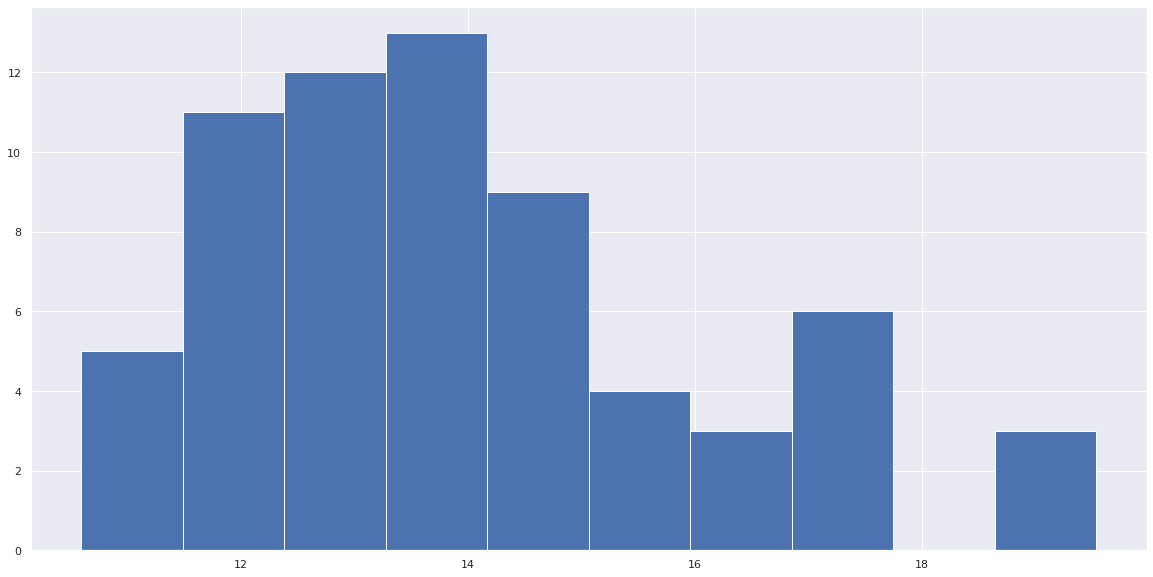

In [372]:
aux.groupby(["a_postcode"]).mean()["minutos_usados"].hist(figsize=(20,10))

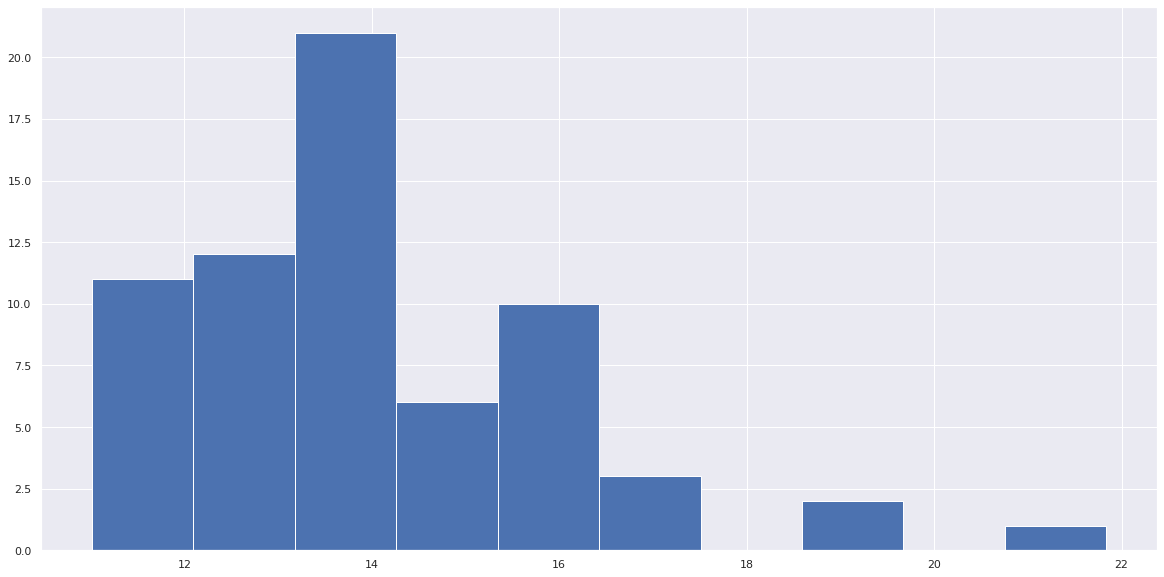

In [373]:
aux.groupby(["r_postcode"]).mean()["minutos_usados"].hist(figsize=(20,10))

In [376]:
test=aux[aux["h_retiro"]==18][["r_county","a_county","Bici"]].groupby(["r_county","a_county"]).count().reset_index()

In [378]:
test

,r_county,a_county,Bici
0,Benito Juárez,Benito Juárez,2144
1,Benito Juárez,Cuauhtémoc,719
2,Benito Juárez,Miguel Hidalgo,212
3,Cuauhtémoc,Benito Juárez,658
4,Cuauhtémoc,Cuauhtémoc,7283
5,Cuauhtémoc,Miguel Hidalgo,719
6,Miguel Hidalgo,Benito Juárez,389
7,Miguel Hidalgo,Cuauhtémoc,2517
8,Miguel Hidalgo,Miguel Hidalgo,1786


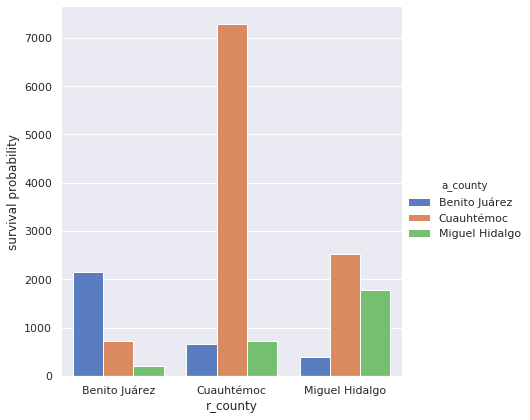

In [379]:
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="r_county", y="Bici", hue="a_county", data=test,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")